In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import math
import pandas as pd
from glob import iglob
import numpy as np
import time
from keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
#from utils import plot_confusion_matrix
import lime
import lime.lime_tabular

Using TensorFlow backend.


In [2]:
print("Loading training data...")
df = pd.concat((pd.read_csv(f) for f in iglob('data/**/benign_traffic.csv', recursive=True)), ignore_index=True)

Loading training data...


In [3]:
x_train, x_opt, x_test = np.split(df.sample(frac=1, random_state=17), [int(1/3*len(df)), int(2/3*len(df))]) #Here I've splitted data equally in three parts

In [4]:
mirai_dataframes = pd.concat((pd.read_csv(f) for f in iglob('data/**/mirai_attacks/*.csv', recursive=True)), ignore_index=True) # This is dataframe comprising of all the mirai attacks

In [5]:
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('data/**/gafgyt_attacks/*.csv', recursive=True)), ignore_index=True) # This is dataframe comprising of all the gafgyt attacks

In [6]:
# Just combining all the malicious dataframes
all_attack_dataframes = mirai_dataframes.append(df_gafgyt)
all_attack_dataframes['class'] = 'attack'

In [7]:
combined_data = x_train.copy()

In [8]:
combined_data['class'] = 'benign'

In [9]:
combined_data = combined_data.append(all_attack_dataframes.sample(n=combined_data.shape[0], random_state=17))

##### Just trying to visualize the dataset, tryna discern some hidden trend

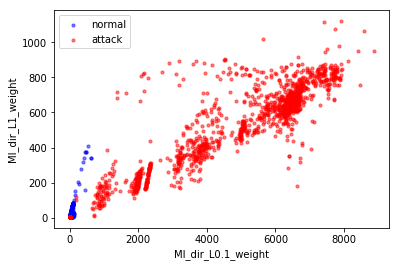

In [10]:
plot_n = 2000
atk = all_attack_dataframes.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()

In [11]:
# This is the function for visualizing confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [12]:
classes = ['benign', 'attack']

In [13]:
scored = []
indices = {} # Indices of both the class, benign and attack. Corresponding to which there's indices of rows which are true for their respective class
shps = {} # Just the total number of each of the class
for cl in classes:
    indices[cl] = combined_data['class'] == cl
    shps[cl] =  combined_data[indices[cl]].shape[0]
        
for col in combined_data.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = combined_data[col].mean()
    
    # Here we are trying to find the score of each of the features, then we can select top 5, 10 or N number of features
    for cl in classes:
        num += (shps[cl] / combined_data.shape[0]) * (m - combined_data[indices[cl]][col].mean())**2
        den += (shps[cl] / combined_data.shape[0]) * combined_data[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 0.841776200583288},
 {'feature': 'H_L0.1_weight', 'score': 0.8417760874874525},
 {'feature': 'MI_dir_L1_weight', 'score': 0.8135489580880652},
 {'feature': 'H_L1_weight', 'score': 0.8135488204361425},
 {'feature': 'MI_dir_L3_weight', 'score': 0.7793888643319505}]

In [14]:
with open('anomaly_scores.csv', 'w+') as file:
    lines = ['Feature,Score\n']
    for s in scored:
        lines.append(s['feature'] + ',' + "{0:.2f}".format(s['score']) + '\n')
    file.writelines(lines)
        

In [15]:
# This is the basic model of our Auto-encoder

def create_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

In [16]:
# This class is for basically operating our model (Autoencoder)

class MainModel:
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)

    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)

        return np.array(classes_arr)

In [17]:
top_n_features=115
fs = [it['feature'] for it in scored[:top_n_features]] #It's basically the list of features (in the order of relevancy)
X_train = x_train[fs] #Shape 92333, 115
X_opt = x_opt[fs] # Same shape as x_train
X_test = x_test[fs] # Same shape as x_train

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_opt = scaler.transform(X_opt)

model = create_model(top_n_features)
model.compile(loss="mean_squared_error",
                optimizer="adam")
cp = ModelCheckpoint(filepath="anomaly/anomaly114.h5", monitor='val_loss', save_best_only=True, verbose=0)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start = time.time()
epochs = 5

#Considering it is an auto-encoder, it's going to try to reconstruct the same input as output, so the input and output data is same, which is x_train. 
# Idea is that while some anomalous input is given to auto-encoder it wont be able to reconstruct the data, as it doesn't follow the normal ternd of the data
# without significant error. 
history = model.fit(X_train, X_train, 
                epochs=epochs,
                validation_data=(X_opt, X_opt),
                verbose=1,
                callbacks=[cp, es])

end = time.time()
print('time')
print(end - start)
print(model.summary())

x_opt_predictions = model.predict(X_opt)
mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
mean = mse.mean()
std = mse.std()


df_benign = pd.DataFrame(x_opt[fs], columns=fs)
df_benign['malicious'] = 0
df_malicious = all_attack_dataframes.sample(n=df_benign.shape[0], random_state=39)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_opt = df2.drop(columns=['malicious']).values
X_opt_scaled = scaler.transform(X_opt)

Y_opt = df2['malicious']
best_acc = 0
best_n = 0
print('Selecting n------------------')
for n in range(1,11):
    tr = mean + n * std
    m = MainModel(model , tr, scaler)
    Y_pred = m.predict(X_opt_scaled)
    print('For n {n}')
    print('Accuracy')
    acc = accuracy_score(Y_opt, Y_pred)
    if acc > best_acc:
        best_acc = acc
        best_n = n
    print(acc)
    print('Precision')
    print(precision_score(Y_opt, Y_pred))
    print('CM')
    print(confusion_matrix(Y_opt, Y_pred))
    #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})

df_benign = pd.DataFrame(X_test, columns=fs)
df_benign['malicious'] = 0
df_malicious = all_attack_dataframes.sample(n=df_benign.shape[0], random_state=17)[fs]
df_malicious['malicious'] = 1
df2 = df_benign.append(df_malicious)
X_test = df2.drop(columns=['malicious']).values
X_test_scaled = scaler.transform(X_test)
Y_test = df2['malicious']

tr = mean + best_n * std
m = MainModel(model , tr, scaler)
Y_pred = m.predict(X_test_scaled)
print('Test-----------------')
print('best n {best_n}')
print('Accuracy')
acc = accuracy_score(Y_test, Y_pred)
print(acc)
print('Precision')
print(precision_score(Y_test, Y_pred))
print('CM')
cm = confusion_matrix(Y_test, Y_pred)
print(cm)   
#print(accs)

Train on 185310 samples, validate on 185311 samples
Epoch 1/5
185310/185310 [==============================] - 17s 94us/step - loss: 0.1450 - val_loss: 0.0743

OSError: Unable to create file (unable to open file: name = 'anomaly/anomaly114.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Opt'], loc='upper left')
plt.show()

In [ ]:
cm

In [ ]:
plot_confusion_matrix(cm, classes, title='Attack detection')

## This program need to use autoencoders (Keras), LOF (local outlier factor), SVM, Isolation forest and classify anomaly traffic or not.

In [ ]:
# This dataset will be used for training
print(X_opt_scaled.shape)
print(Y_opt.shape)

In [ ]:
# This dataset will be used for testing
print(X_test_scaled.shape)
print(Y_test.shape)

### Local Outlier Factor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pickle

In [ ]:
lof = LocalOutlierFactor(novelty=True, n_jobs=-1)
lof.fit(X_opt_scaled)

In [ ]:
prediction = lof.predict(X_test_scaled)

In [ ]:
prediction[prediction<1] = 0

In [ ]:
accuracy_score(prediction, Y_test)

In [ ]:
plot_confusion_matrix(prediction, Y_test, ['benign', 'attack'])

### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
iso = IsolationForest(n_jobs=-1)

In [ ]:
iso.fit(X_opt_scaled)

In [ ]:
with open('iso.pkl', 'wb+') as handle:
    pickle.dump(iso, handle)

In [ ]:
prediction = iso.predict(X_test_scaled)

In [ ]:
prediction[prediction<1] = 0

In [ ]:
accuracy_score(prediction, Y_test)

In [ ]:
plot_confusion_matrix(prediction, Y_test, ['benign', 'attack'])

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC()

In [ ]:
svm.fit(X_opt_scaled, Y_opt)

In [ ]:
X_test_scaled.shape

In [ ]:
prediction = svm.predict(X_test_scaled)

In [ ]:
np.unique(prediction, return_counts=True)

In [ ]:
accuracy_score(prediction, Y_test)

In [ ]:
plot_confusion_matrix(prediction, Y_test, ['benign', 'attack'])